## Proof of Concept for flood maps

This notebook is an attempt at translating the CoCliCo User Story into code. 

The data used is Coastal Flood Hazard Projections and can be found here: p:\11207608-coclico\FULLTRACK_DATA\WP4\

In [1]:
# Import modules

import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib
import pystac
import geopandas as gpd

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# ignore warnings
warnings.filterwarnings("ignore")

C:\Users\soest\AppData\Local\Temp\ipykernel_11392\811421884.py:18: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [2]:
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/catalog.json"
)
collection = catalog.get_child(id = 'cfhp')

In [3]:
item = pystac.Item.from_file('https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/cfhp/items/UNDEFENDED_MAPS/RP/1000/B01_epsg%3D3035_x%3D2366962_y%3D3777262.json')
ds = rio.open_rasterio(item.assets['band_data'].href)
ds

Exception: Could not read uri https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/cfhp/items/UNDEFENDED_MAPS/RP/1000/B01_epsg%3D3035_x%3D2366962_y%3D3777262.json

In [4]:
# Load LAU's 

# Set file path
lau_fp = r"p:\11207608-coclico\FASTTRACK_DATA\XX_LAU\LAU_RG_01M_2020_3035.shp"

# Load data
lau_data = gpd.read_file(lau_fp)

<Axes: >

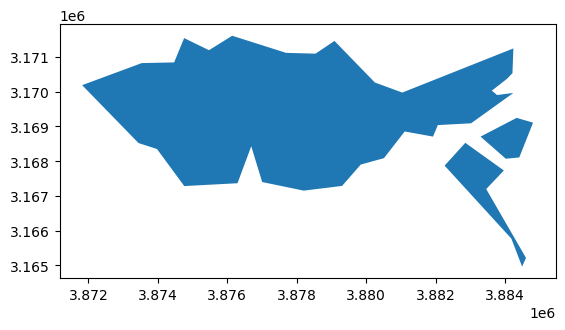

In [5]:
# Filter on the Netherlands as an example
lau_NL = lau_data.loc[lau_data["CNTR_CODE"] == "NL"] 

# Select one for testing
lau = lau_data.loc[lau_data["LAU_NAME"] == "Vlissingen"] 

lau.plot()

In [68]:
# intersecting_items = []
# for item in collection.get_items():
#     item_geometry = item.geometry
#     if item_geometry.intersects(lau['geometry'].unary_union):
#         intersecting_items.append(item)

AttributeError: 'dict' object has no attribute 'intersects'

In [6]:
for i, item in enumerate(collection.get_all_items()):
    
    if "UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=3186162_y=2958337.tif" in item.id:
        print(item.id)
        print(i)
        break


UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=3186162_y=2958337.tif
912


In [106]:
from shapely.geometry import shape

cur_item_geom = gpd.GeoDataFrame(geometry=[shape(item.geometry)])

[item_geom] = item.properties['proj:geometry']['coordinates']


<Item id=UNDEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=6462962_y=941637.tif>

In [107]:
item

<Item id=UNDEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=6462962_y=941637.tif>

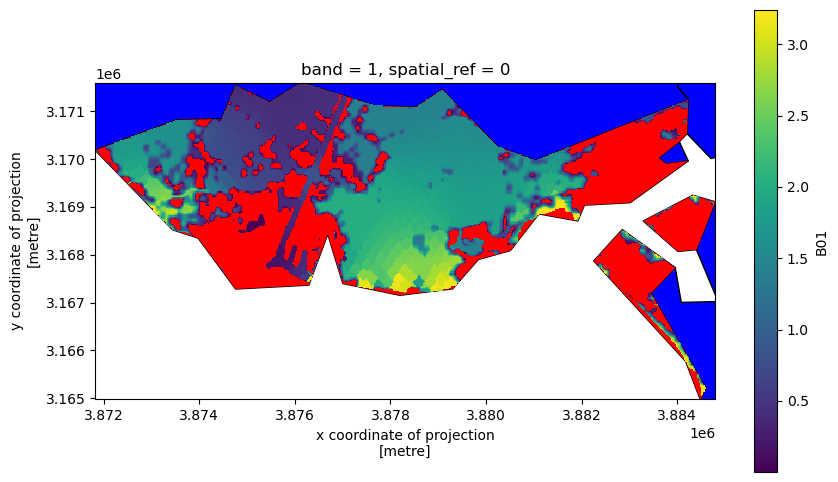

In [108]:
item_test = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_geom)])

# Generate figure
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau_NL.plot(ax=ax, color='blue', edgecolor='black')
lau.plot(ax=ax, color='red')


for i, cur_lau in lau.iterrows():
    
    if cur_lau['geometry'].intersects(item_test['geometry'])[0]:

        print(cur_lau['geometry'])
        print(item_test['geometry'])
        
        print('Working on: ' + str(cur_lau['LAU_NAME']))
        # Load raw band_data dataset 
        ds = rio.open_rasterio(item.assets['band_data'].href)

        # Clip dataset to match AOI
        ds_clip = ds.rio.clip(cur_lau)

# Adjust FillValue (NoData) to np.nan for plotting purposes
ds_clip = ds_clip.where(ds_clip != ds_clip.attrs['_FillValue'],np.nan)
# Plot data
ds_clip.plot(ax=ax)

In [112]:
print(type(shapely.Polygon(lau.geometry)))
print(type(item_test['geometry']))

TypeError: 'MultiPolygon' object is not iterable

In [69]:
# Compute statistics

# Amount of noData's within dataset clipped to polygon
n_nans = np.isnan(ds_clip.values).sum()
n_less05 = np.array([ds_clip.values<0.5]).sum()
n_more05 = np.array([ds_clip.values>0.5]).sum()

total = n_nans + n_less05 + n_more05

print('summed pixels = ' + str(total))
print('original pixels = ' + str(np.size(ds_clip.values)))

summed pixels = 137535
original pixels = 137535


Text(0.5, 1.0, 'Percentage flooded = 37%')

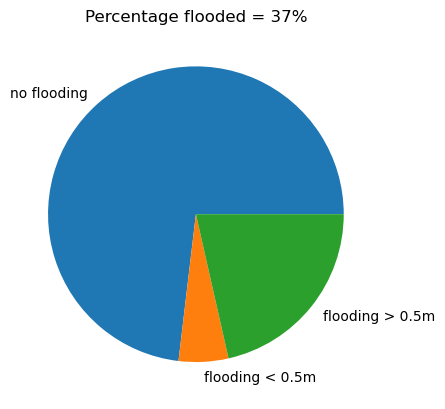

In [72]:
# Plot data
import matplotlib.pyplot as plt

# Set labels
labels = 'no flooding','flooding < 0.5m', 'flooding > 0.5m'
# Initiate figure
fig, ax = plt.subplots()
# Do plotting
ax.pie(np.array([n_nans,n_less05,n_more05]), labels = labels)
ax.set_title('Percentage flooded = ' + str(round((n_less05+n_more05)/n_nans*100)) + '%')

In [75]:
import os

# Set up folder structure
folder_structure = {
    "Mean_spring_tide": [],
    "RP": ["1000", "100", "1"],
    "SLR": {
        "High_end": ["2100", "2150"],
        "SSP126": ["2100"],
        "SSP245": ["2050", "2100"],
        "SSP585": ["2030", "2050", "2100"]
    }
}

def get_paths(folder_structure, base_dir=''):
    """Generate paths for a folder structure defined by a dict"""
    paths = []
    for key, value in folder_structure.items():
        if isinstance(value, dict):
            paths.extend(get_paths(value, os.path.join(base_dir, key)))
        elif isinstance(value, list):
            if value:
                for item in value:
                    if item != "":
                        paths.append(os.path.join(base_dir, key, item))
            else:
                paths.append(os.path.join(base_dir, key))
        else:
            continue
    return paths

path_list = get_paths(folder_structure)
path_list


['Mean_spring_tide',
 'RP\\1000',
 'RP\\100',
 'RP\\1',
 'SLR\\High_end\\2100',
 'SLR\\High_end\\2150',
 'SLR\\SSP126\\2100',
 'SLR\\SSP245\\2050',
 'SLR\\SSP245\\2100',
 'SLR\\SSP585\\2030',
 'SLR\\SSP585\\2050',
 'SLR\\SSP585\\2100']

In [103]:
# Load all scenarios
from pathlib import Path

for item in collection.get_all_items():
    for cur_path in path_list:
    
        if  str(Path(cur_path).as_posix()) + "/B01_epsg=3035_x=3186162_y=2958337.tif" in item.id:
            print(item.id)
            break
        

HIGH_DEFENDED_MAPS/SLR/High_end/2100/B01_epsg=3035_x=3186162_y=2958337.tif
HIGH_DEFENDED_MAPS/SLR/High_end/2150/B01_epsg=3035_x=3186162_y=2958337.tif
HIGH_DEFENDED_MAPS/SLR/SSP126/2100/B01_epsg=3035_x=3186162_y=2958337.tif
HIGH_DEFENDED_MAPS/SLR/SSP245/2100/B01_epsg=3035_x=3186162_y=2958337.tif
HIGH_DEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=3186162_y=2958337.tif
LOW_DEFENDED_MAPS/SLR/High_end/2100/B01_epsg=3035_x=3186162_y=2958337.tif
LOW_DEFENDED_MAPS/SLR/High_end/2150/B01_epsg=3035_x=3186162_y=2958337.tif
LOW_DEFENDED_MAPS/SLR/SSP126/2100/B01_epsg=3035_x=3186162_y=2958337.tif
LOW_DEFENDED_MAPS/SLR/SSP245/2100/B01_epsg=3035_x=3186162_y=2958337.tif
LOW_DEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=3186162_y=2958337.tif
UNDEFENDED_MAPS/Mean_spring_tide/B01_epsg=3035_x=3186162_y=2958337.tif
UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=3186162_y=2958337.tif
UNDEFENDED_MAPS/RP/100/B01_epsg=3035_x=3186162_y=2958337.tif
UNDEFENDED_MAPS/RP/1/B01_epsg=3035_x=3186162_y=2958337.tif
UNDEFENDED_MAP

In [95]:
Path(path_list[4]).as_posix()

'SLR/High_end/2100'

In [98]:
str(Path(path_list[4]).as_posix()) + "/B01_epsg=3035_x=31*_y=29*.tif"

'SLR/High_end/2100/B01_epsg=3035_x=31*_y=29*.tif'